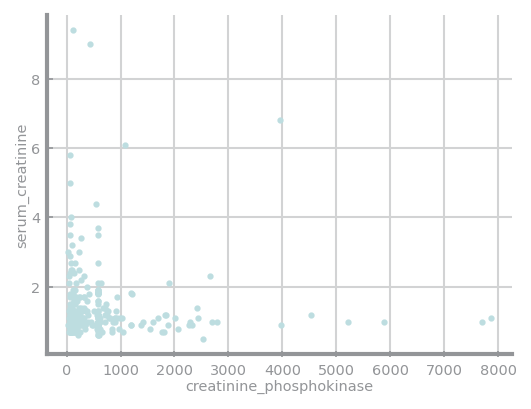

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds

data: pd.DataFrame = pd.read_csv('data/heart_failure_clinical_records_dataset.csv')
    
data.pop('time')
data.pop('DEATH_EVENT')

variables = data.columns.values
eixo_x = 0
eixo_y = 2
eixo_z = 7

plt.figure()
plt.xlabel(variables[eixo_y])
plt.ylabel(variables[eixo_z])
plt.scatter(data.iloc[:, eixo_y], data.iloc[:, eixo_z])
plt.show()

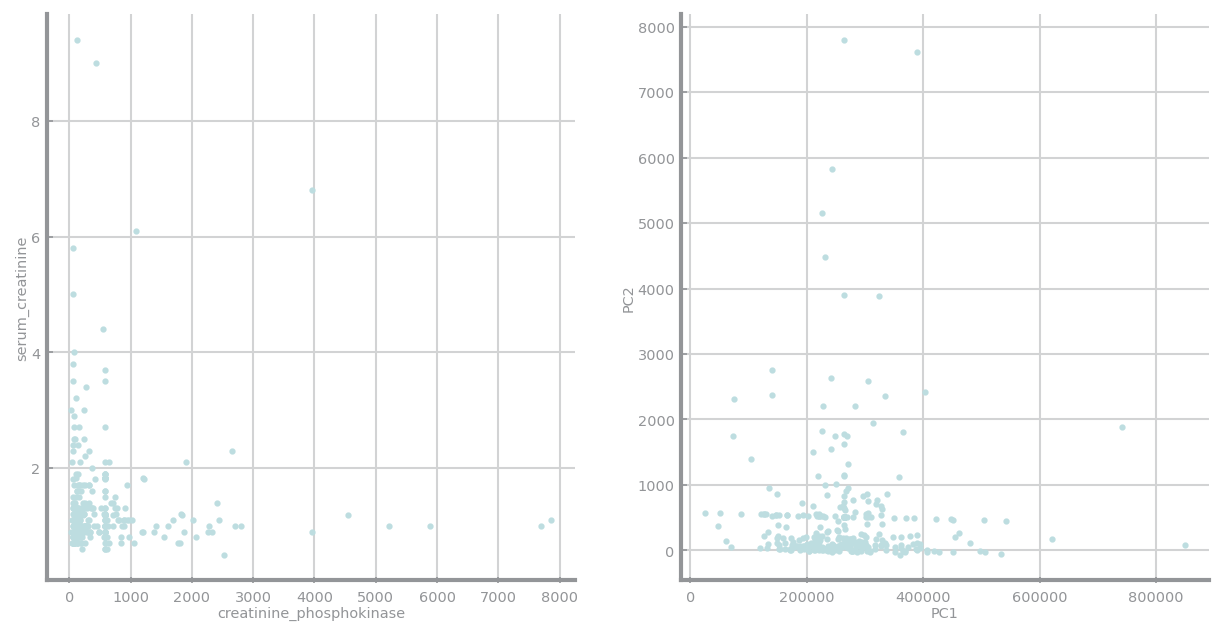

In [16]:
transf = pca.transform(data)

_, axs = plt.subplots(1, 2, figsize=(2*5, 1*5), squeeze=False)
axs[0,0].set_xlabel(variables[eixo_y])
axs[0,0].set_ylabel(variables[eixo_z])
axs[0,0].scatter(data.iloc[:, eixo_y], data.iloc[:, eixo_z])

axs[0,1].set_xlabel('PC1')
axs[0,1].set_ylabel('PC2')
axs[0,1].scatter(transf[:, 0], transf[:, 1])
plt.show()